# Домашнее задание №2

**SQLite как пример СУБД для работы с реляционными БД.**

Дан csv-файл с транзакциями с 2023–01-01 до 2023-04-20. Необходимо в Jupyter-ноутбуке выполнить следующие пункты, используя SQLite:

Необходимо скачать CSV-файл — «final_transactions.csv», создать таблицу transaction_bd со всеми полями, загрузить данные из файла в таблицу и оставить таблицу со структурой:

(0, 'TX_DATETIME', 'NUMERIC', 0, None, 0) - время транзакций

(1, 'CUSTOMER_ID', 'INTEGER', 0, None, 0) - клиент

(2, 'TX_AMOUNT', 'REAL', 0, None, 0) - сумма транзакций

Импортируем таблицу:

In [ ]:
import pandas as pd
url_file = 'https://drive.google.com/file/d/1_YrZPaD1zNCcXUkUfeWM0ZOdg_was_iA/view'
main = 'https://drive.google.com/uc?id='
id_url = url_file.split('/')[-2]
direct_url = main + id_url
transaction_bd = pd.read_csv(direct_url)

In [ ]:
transaction_bd.drop('TERMINAL_ID', axis=1, inplace=True)

In [ ]:
transaction_bd.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TX_AMOUNT
0,0,2023-01-01 00:00:31,596,533.07
1,1,2023-01-01 00:02:10,4961,808.56
2,2,2023-01-01 00:07:56,2,1442.94
3,3,2023-01-01 00:09:29,4128,620.65
4,4,2023-01-01 00:10:34,927,490.66


In [ ]:
import sqlite3
from sqlite3 import Error

Подключаемся к БД:

In [ ]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
connection = create_connection("myhw.db")

Connection to SQLite DB successful


Функция выполнения запроса к базе данных:

In [ ]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

Функция для добавления значений в таблицу:

In [ ]:
def sql_insert(connection, data, name, m=0, n=transaction_bd.shape[1]):
    cursor = connection.cursor()
    try:
        cursor.executemany(f"""
                INSERT INTO {name} {tuple(data.columns[m:n])} 
                    VALUES ({str("?, " * (n-m-1) + "?")})""",
                data.iloc[:, m:n].values)
        connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")

In [ ]:
create_users_table = """
    CREATE TABLE IF NOT EXISTS transactions (
        transaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
        tx_datetime NUMERIC NOT NULL,
        customer_id INTEGER NOT NULL,
        tx_amount REAL NOT NULL
    );
    """
execute_query(connection, create_users_table)

Query executed successfully


In [ ]:
sql_insert(connection, transaction_bd, 'transactions')

The error 'UNIQUE constraint failed: transactions.transaction_id' occurred


In [ ]:
pd.read_sql('SELECT * FROM transactions', connection)

,transaction_id,tx_datetime,customer_id,tx_amount
0,0,2023-01-01 00:00:31,596,533.07
1,1,2023-01-01 00:02:10,4961,808.56
2,2,2023-01-01 00:07:56,2,1442.94
3,3,2023-01-01 00:09:29,4128,620.65
4,4,2023-01-01 00:10:34,927,490.66
...,...,...,...,...
1048570,1048570,2023-04-20 10:07:13,2380,325.64
1048571,1048571,2023-04-20 10:07:28,738,20.38
1048572,1048572,2023-04-20 10:07:33,1000,182.79
1048573,1048573,2023-04-20 10:07:39,3028,455.44


A. Вывести всех клиентов, у которых сумма транзакций больше 700000 за весь период (сортируя клиентов по возрастанию);

In [ ]:
pd.read_sql("""select customer_id, sum(tx_amount) 
               from transactions 
               group by 1 
               having sum(tx_amount)>700000 
               order by customer_id"""
            , connection)

,customer_id,sum(tx_amount)
0,389,753411.90
1,2249,707478.64
2,2891,786115.87
3,3116,721980.69
4,4163,765153.63


B. Вывести всех клиентов, у которых сумма транзакций больше 200000 за период 01.01.2023 - 13.01.2023 (сортируя клиентов по возрастанию);

In [ ]:
pd.read_sql("""select customer_id, sum(tx_amount) 
               from transactions 
               where date(tx_datetime) between '2023-01-01' and '2023-01-13' 
               group by 1 
               having sum(tx_amount)>200000 
               order by 1"""
            , connection)

,customer_id,sum(tx_amount)
0,1918,241299.96
1,3406,207733.48
2,3833,269107.40
3,4252,220650.36


C. Вывести тех клиентов, у которых id начинается с 4 и количество транзакций за весь период более 444;

In [ ]:
pd.read_sql("""select customer_id, count(transaction_id)
               from transactions
               where customer_id like '4%'
               group by 1
               having count(transaction_id)>444
               order by 1"""
            , connection)

,customer_id,count(transaction_id)
0,4231,451
1,4539,445
2,4661,449


D. Создать флаг доходности клиентов по логике:
1. Если сумма транзакций не более 50000, тогда вывести 'низкая доходность';
2. Если сумма транзакций больше 50000 и не более 10000 тогда вывести 'средняя доходность';
3. Если сумма транзакций больше 100000 тогда вывести 'высокая доходность'.

In [ ]:
pd.read_sql("""select customer_id, sum(tx_amount), 
                      case when sum(tx_amount)<=50000 then 'низкая доходность'
                           when sum(tx_amount)>50000 and sum(tx_amount)<=100000 then 'средняя доходность'
                           else 'высокая доходность'
                      end as income_flag
                from transactions
                group by 1
                order by 1"""
           , connection)

,customer_id,sum(tx_amount),income_flag
0,0,119568.47,высокая доходность
1,1,323510.82,высокая доходность
2,2,162541.90,высокая доходность
3,3,2406.56,низкая доходность
4,4,300589.33,высокая доходность
...,...,...,...
4981,4995,149962.31,высокая доходность
4982,4996,27135.67,низкая доходность
4983,4997,131288.62,высокая доходность
4984,4998,337988.39,высокая доходность


E. Посмотреть количество клиентов с каждым видом доходности (из пункта 2.d);

In [ ]:
pd.read_sql("""with income as (select customer_id, sum(tx_amount), 
                      case when sum(tx_amount)<=50000 then 'низкая доходность'
                           when sum(tx_amount)>50000 and sum(tx_amount)<=100000 then 'средняя доходность'
                           else 'высокая доходность'
                      end as income_flag
                from transactions
                group by 1
                order by 1)
                select count(customer_id)
                from income
                group by income_flag"""
           , connection)

,count(customer_id)
0,2167
1,1812
2,1007


F. Вывести сумму транзакций за каждый день (сортируя дни по возрастанию).

In [ ]:
pd.read_sql("""select date(tx_datetime), sum(tx_amount)
               from transactions
               group by 1
               order by 1"""
            , connection)

,date(tx_datetime),sum(tx_amount)
0,2023-01-01,4827656.26
1,2023-01-02,4862551.41
2,2023-01-03,5058973.71
3,2023-01-04,4938142.47
4,2023-01-05,5002954.23
...,...,...
105,2023-04-16,5299386.81
106,2023-04-17,5100973.31
107,2023-04-18,5233557.39
108,2023-04-19,5194846.44


Подготовить дашборд с помощью Dash по пункту 2.f, включив туда графики bar и histogram; вставить в конце ноутбука скрин графиков из дашборда.

In [ ]:
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash()

df1=pd.read_sql("""select date(tx_datetime) as tx_date, sum(tx_amount) as tx_sum
               from transactions
               group by 1
               order by 1"""
            , connection)
fig1 = px.bar(df1, x="tx_date", y="tx_sum")
fig2 = px.histogram(df1, x='tx_sum', nbins=40)
app.layout = html.Div(children=[
    html.H1(children='Данные по сумме транзакций'),

    html.Div(children='''
        Сумма транзакций в разрезе дат.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig1
    ),
    html.Div(children='''
        Распределение сумм транзакций.
    '''),
     dcc.Graph(
        id='example-graph1',
        figure=fig2
    )
])
app.run_server()

C:\Users\никита\AppData\Local\Temp\ipykernel_17108\1413397042.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\никита\AppData\Local\Temp\ipykernel_17108\1413397042.py:4: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [31/Mar/2023 15:42:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 15:42:05] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 15:42:05] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [31/Mar/2023 15:42:05] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [31/Mar/2023 15:42:05] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


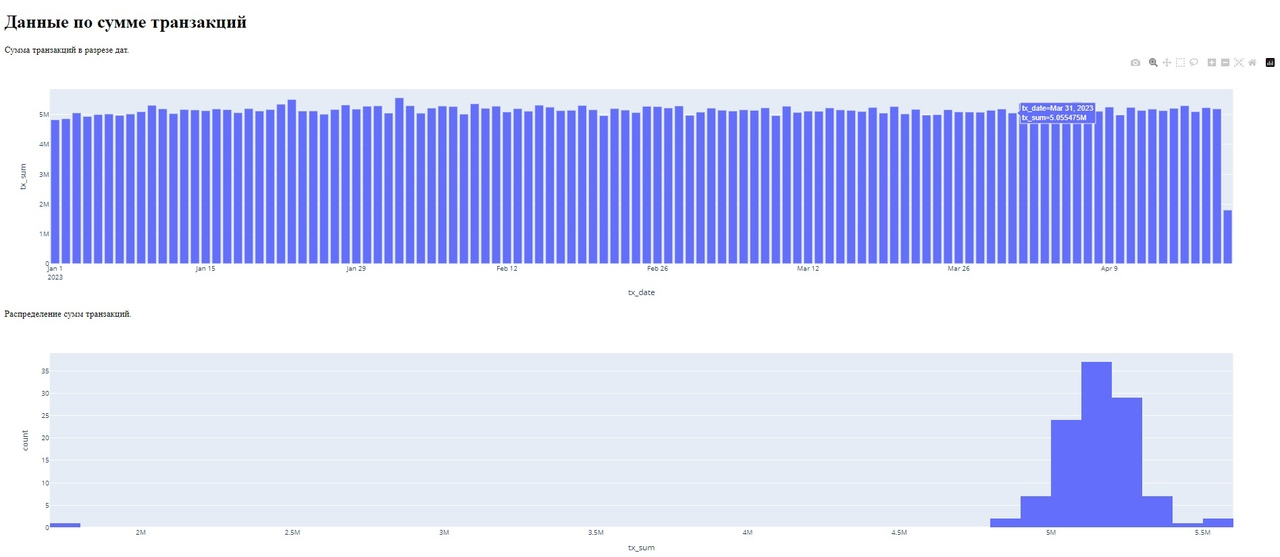

In [ ]:
connection.close()